In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

# Load the VGG16 model with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)
# Add Global Average Pooling layer
x = GlobalAveragePooling2D()(base_model.output)
# Create a model that includes the VGG16 base model and GAP layer

model = Model(inputs=base_model.input, outputs=x)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Directory paths
cats_directory = '/content/drive/MyDrive/Colab Notebooks/newDataSet/cats_and_dogs_filtered/train/cats'
dogs_directory = '/content/drive/MyDrive/Colab Notebooks/newDataSet/cats_and_dogs_filtered/train/dogs'

# Lists to store features and labels
all_features = []
all_labels = []

# Load cat images
for cat_filename in os.listdir(cats_directory):
    cat_img_path = os.path.join(cats_directory, cat_filename)
    cat_features = model.predict(preprocess_image(cat_img_path))
    all_features.append(cat_features)
    all_labels.append(0)  # Assuming label 0 for cats

# Load dog images
for dog_filename in os.listdir(dogs_directory):
    dog_img_path = os.path.join(dogs_directory, dog_filename)
    dog_features = model.predict(preprocess_image(dog_img_path))
    all_features.append(dog_features)
    all_labels.append(1)  # Assuming label 1 for dogs

# Convert lists to arrays
all_features = np.concatenate(all_features, axis=0)
all_labels = np.array(all_labels)

1/1 [==============================] - 1s 858ms/step


In [4]:
# Directory paths
cats_directory = '/content/drive/MyDrive/Colab Notebooks/newDataSet/cats_and_dogs_filtered/validation/cats'
dogs_directory = '/content/drive/MyDrive/Colab Notebooks/newDataSet/cats_and_dogs_filtered/validation/dogs'

# Lists to store features and labels
all_validation_features = []
all_validation_labels = []

# Load cat images
for cat_filename in os.listdir(cats_directory):
    cat_img_path = os.path.join(cats_directory, cat_filename)
    cat_features = model.predict(preprocess_image(cat_img_path))
    all_validation_features.append(cat_features)
    all_validation_labels.append(0)  # Assuming label 0 for cats

# Load dog images
for dog_filename in os.listdir(dogs_directory):
    dog_img_path = os.path.join(dogs_directory, dog_filename)
    dog_features = model.predict(preprocess_image(dog_img_path))
    all_validation_features.append(dog_features)
    all_validation_labels.append(1)  # Assuming label 1 for dogs

# Convert lists to arrays
all_validation_features = np.concatenate(all_validation_features, axis=0)
all_validation_labels = np.array(all_validation_labels)

1/1 [==============================] - 1s 965ms/step


In [5]:

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix

# SVM
svm_model = SVC(probability=True)
svm_model.fit(all_features, all_labels)
svm_probs = svm_model.predict_proba(all_validation_features)[:, 1]
svm_auc = roc_auc_score(all_validation_labels, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(all_validation_labels, svm_probs)

# MLP
mlp_model = MLPClassifier()
mlp_model.fit(all_features, all_labels)
mlp_probs = mlp_model.predict_proba(all_validation_features)[:, 1]
mlp_auc = roc_auc_score(all_validation_labels, mlp_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(all_validation_labels, mlp_probs)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(all_features, all_labels)
rf_probs = rf_model.predict_proba(all_validation_features)[:, 1]
rf_auc = roc_auc_score(all_validation_labels, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(all_validation_labels, rf_probs)


Results for SVM:
Accuracy: 0.9910
F Score: 0.9910
AUC: 0.9996

Confusion Matrix:
[[495   5]
 [  4 496]]


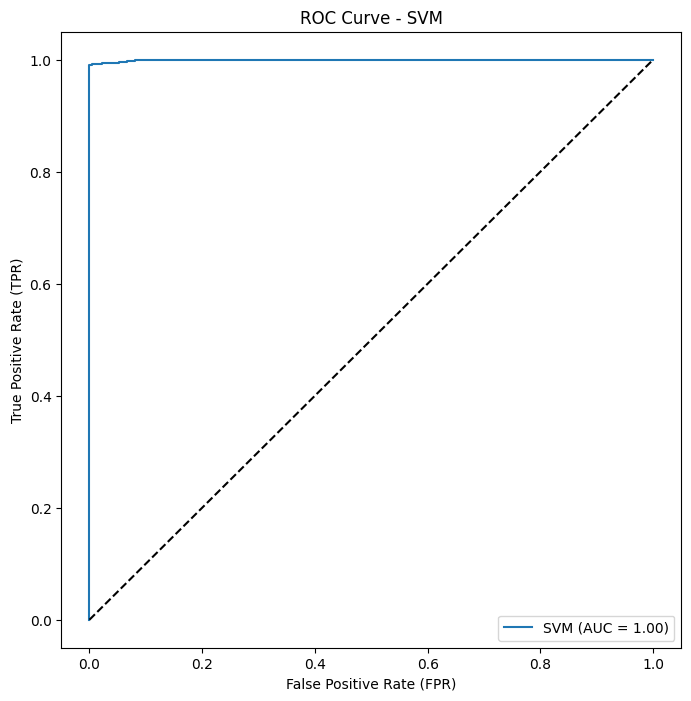

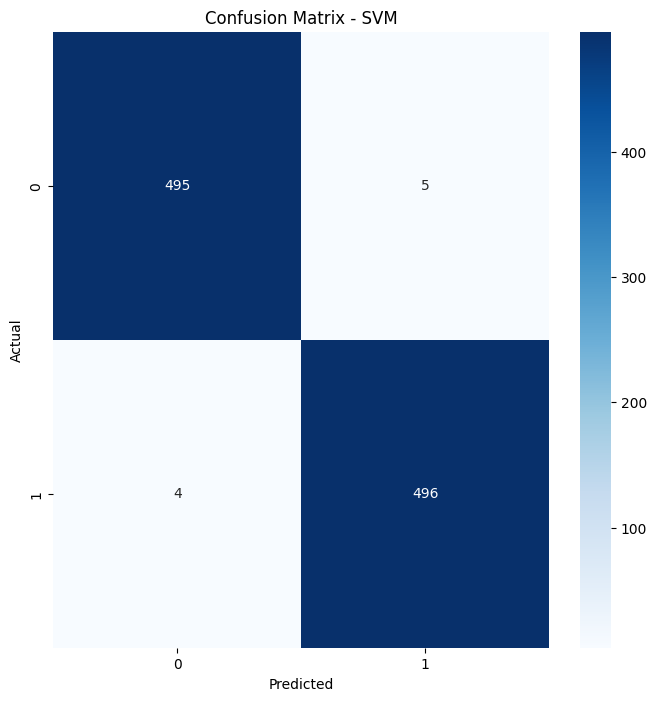


Results for MLP:
Accuracy: 0.9800
F Score: 0.9800
AUC: 0.9987

Confusion Matrix:
[[491   9]
 [ 11 489]]


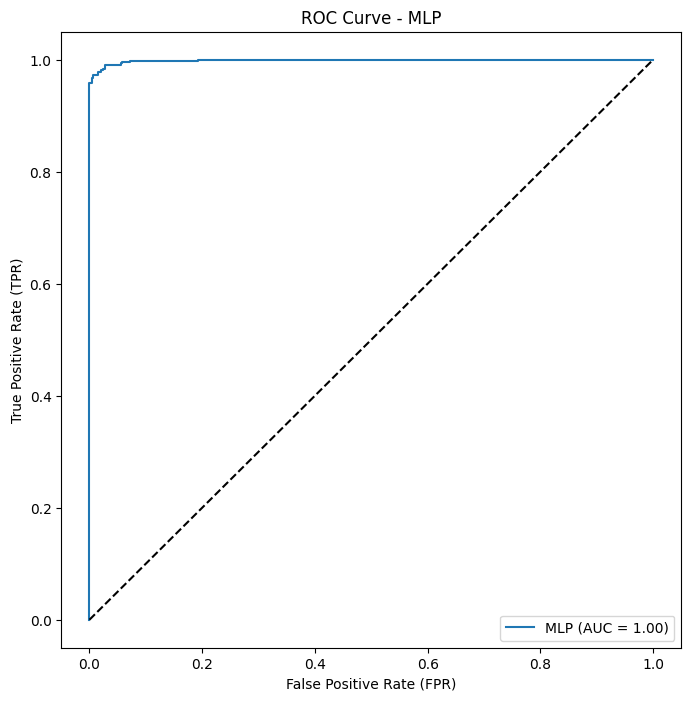

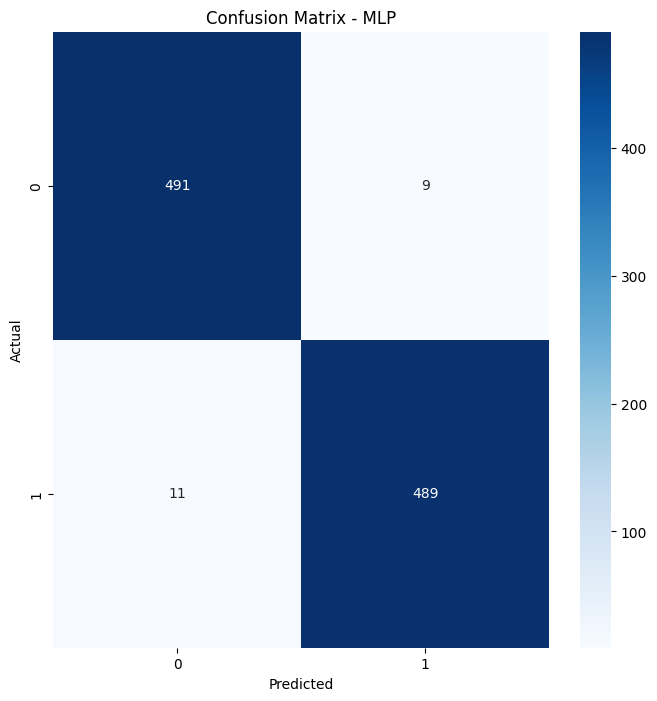


Results for Random Forest:
Accuracy: 0.9800
F Score: 0.9801
AUC: 0.9988

Confusion Matrix:
[[487  13]
 [  7 493]]


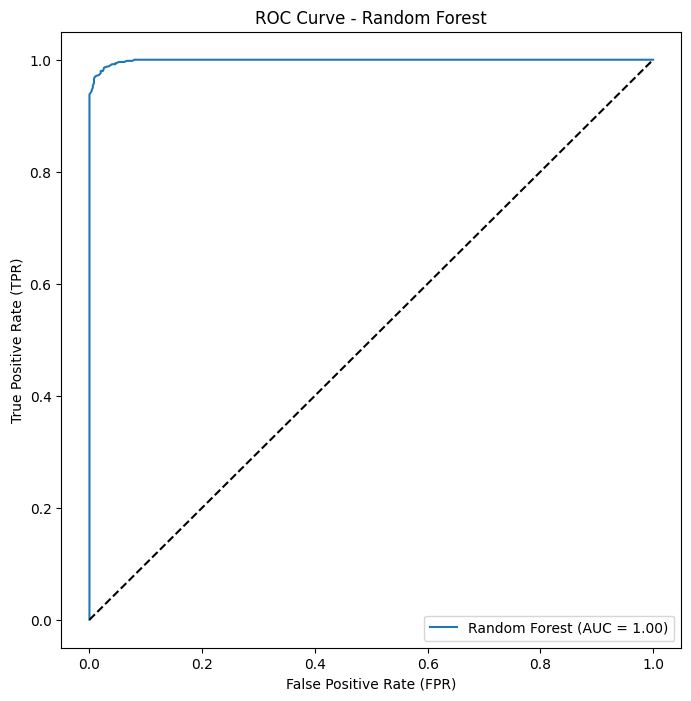

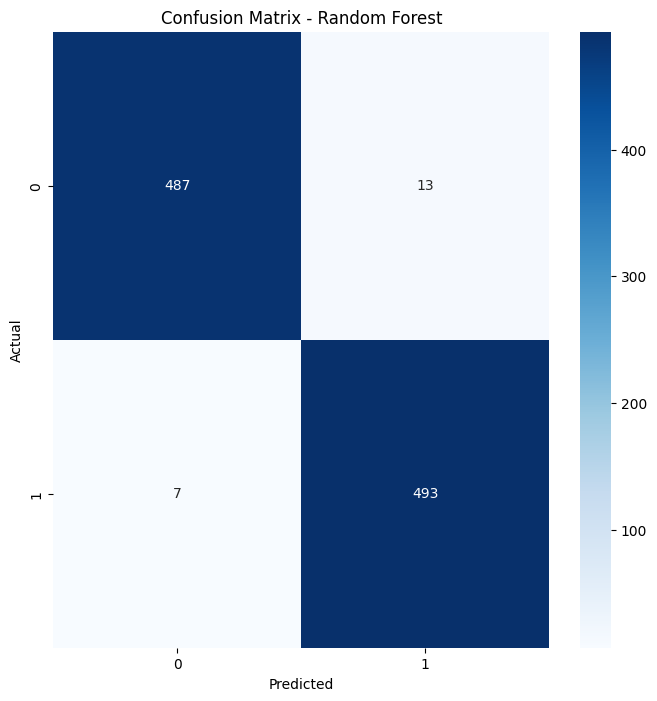

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# Helper function to print and visualize results
def print_and_plot_results(model_name, y_true, y_pred_probs, fpr, tpr, auc):
    # Calculate additional metrics
    y_pred = (y_pred_probs > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F Score: {f_score:.4f}")
    print(f"AUC: {auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()
    # Visualize confusion matrix
    import seaborn as sns
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate and visualize SVM
print_and_plot_results("SVM", all_validation_labels, svm_probs, svm_fpr, svm_tpr, svm_auc)

# Evaluate and visualize MLP
print_and_plot_results("MLP", all_validation_labels, mlp_probs, mlp_fpr, mlp_tpr, mlp_auc)

# Evaluate and visualize Random Forest
print_and_plot_results("Random Forest", all_validation_labels, rf_probs, rf_fpr, rf_tpr, rf_auc)

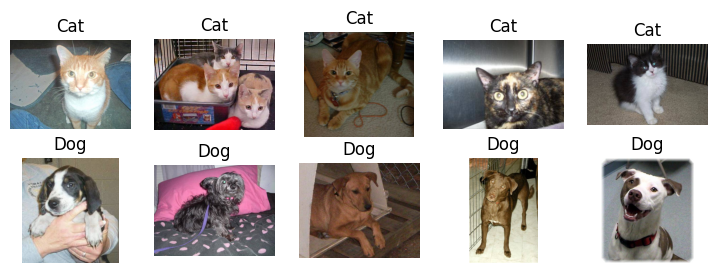

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cats_directory = '/content/drive/MyDrive/Colab Notebooks/newDataSet/cats_and_dogs_filtered/train/cats'
dogs_directory = '/content/drive/MyDrive/Colab Notebooks/newDataSet/cats_and_dogs_filtered/train/dogs'

fig, axes = plt.subplots(2, 5, figsize=(9, 3))
axes = axes.ravel()

# Plot first 5 images of cats
for i in range(5):
    cat_image_path = os.path.join(cats_directory, os.listdir(cats_directory)[i])
    cat_img = mpimg.imread(cat_image_path)
    axes[i].imshow(cat_img)
    axes[i].set_title('Cat')
    axes[i].axis('off')

# Plot first 5 images of dogs
for i in range(5):
    dog_image_path = os.path.join(dogs_directory, os.listdir(dogs_directory)[i])
    dog_img = mpimg.imread(dog_image_path)
    axes[i+5].imshow(dog_img)
    axes[i+5].set_title('Dog')
    axes[i+5].axis('off')

plt.show()